In [1]:
import numpy as np
import pandas as pd

from statsmodels.tsa.api import ARIMA
from statsmodels.stats.api import het_arch, acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_predict

import pandas_datareader.data as web

# настройки визуализации
import matplotlib.pyplot as plt

# Не показывать Warnings
import warnings
warnings.simplefilter(action='ignore', category=Warning)
# Не показывать ValueWarning, ConvergenceWarning из statsmodels
from statsmodels.tools.sm_exceptions import ValueWarning, ConvergenceWarning
warnings.simplefilter('ignore', category=ValueWarning)
warnings.simplefilter('ignore', category=ConvergenceWarning)

<Axes: xlabel='DATE'>

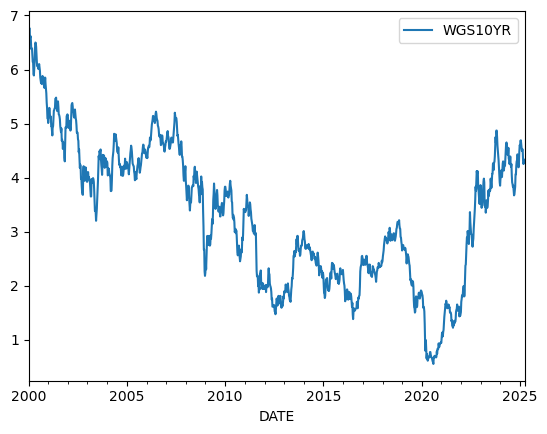

In [3]:
y = web.DataReader(name='WGS10YR', data_source='fred', start='2000-01-01')
y.plot()

In [4]:
# спецификация модели
mod = ARIMA(y, order=(2,1,1), trend='n', missing='drop')
# подгонка модели на данных
res = mod.fit()
# выводим результаты подгонки
res.summary(alpha=0.05)

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                WGS10YR   No. Observations:                 1317
Model:                 ARIMA(2, 1, 1)   Log Likelihood                1193.078
Date:                Tue, 01 Apr 2025   AIC                          -2378.156
Time:                        09:25:12   BIC                          -2357.427
Sample:                    01-07-2000   HQIC                         -2370.383
                         - 03-28-2025                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1127      4.501      0.025      0.980      -8.709       8.934
ar.L2          0.0216      1.029      0.021      0.983      -1.995       2.038
ma.L1          0.1163      4.502      0.026      0.979      -8.707       8.939
sigma2         0.0095      0.000     32.163      0.000       0.009       0.010
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                82.51
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               0.92   Skew:                            -0.00
Prob(H) (two-sided):                  0.40   Kurtosis:                         4.23
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

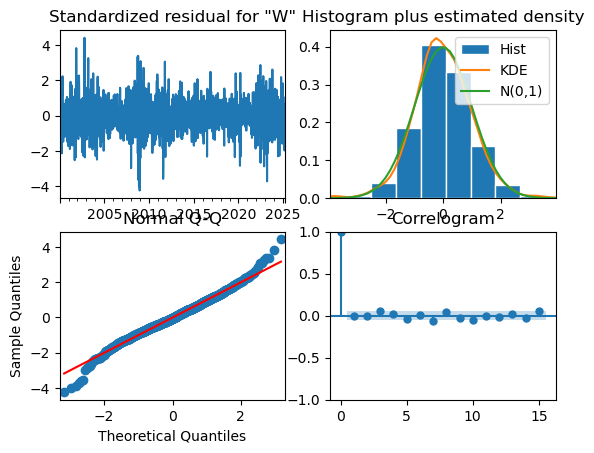

In [5]:
res.plot_diagnostics(lags=15)

plt.show()

# Auotocorrelation test

In [6]:
# корректировка степеней свободы: число оцениваемых коэффициентов = число параметров - 1 (-sigma2)
model_df = mod.k_params-1
# для тест отбрасываем первые d остатков (d=mod.k_diff)
acorr_ljungbox(res.resid[mod.k_diff:] , lags=[6], model_df=model_df)

,lb_stat,lb_pvalue
6,7.312524,0.062576


### Серийная корреляция отсутствует

# Тест на гетероскедастичность (на ARCH-эффекты)


In [7]:
# корректировка степеней свободы: число оцениваемых коэффициентов = число параметров - 1 (-sigma2)
model_df = mod.k_params-1
# для тест отбрасываем первые d остатков (d=mod.k_diff)
lm_stat, lm_pval, f_stat, f_pval = het_arch(res.resid[mod.k_diff:], nlags=6, ddof=model_df)

lm_stat, lm_pval

(134.73848590801035, 1.2903097578341908e-26)

In [12]:
from scipy.stats import chi2
print('CHI2_crit = ', chi2.isf(0.05, df=6-model_df))

CHI2_crit =  7.814727903251178


### Гетероскедастичность присутствует

In [13]:
import numpy as np
import pandas as pd

from sktime.forecasting.arima import ARIMA, AutoARIMA
# from sktime.forecasting.arima import StatsModelsARIMA
# from sktime.forecasting.statsforecast import StatsForecastAutoARIMA
from sktime.utils.plotting import plot_series
# временной горизонт для прогнозирования
from sktime.forecasting.base import ForecastingHorizon

import pandas_datareader.data as web

# тесты диагностики
from statsmodels.stats.diagnostic import het_arch, acorr_ljungbox

# настройки визуализации
import matplotlib.pyplot as plt

# Не показывать Warnings
import warnings
warnings.simplefilter(action='ignore', category=Warning)
# Не показывать ValueWarning, ConvergenceWarning из statsmodels
from statsmodels.tools.sm_exceptions import ValueWarning, ConvergenceWarning
warnings.simplefilter('ignore', category=ValueWarning)
warnings.simplefilter('ignore', category=ConvergenceWarning)

In [15]:
y = web.DataReader(name='WGS10YR', data_source='fred', start='2000-01-01')

In [16]:
forecaster = AutoARIMA(information_criterion='bic', test='kpss', seasonal=True)
forecaster.fit(y)
forecaster.get_fitted_params() #['order']

{'ar.L1': 0.22772508877865968,
 'sigma2': 0.009551265278030255,
 'order': (1, 1, 0),
 'seasonal_order': (0, 0, 0, 0),
 'aic': -2382.1243439820464,
 'aicc': -2382.1152046065704,
 'bic': -2371.759639758276,
 'hqic': -2378.237836295654}